# Linear Regressions

## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver
import re              # Regular Expressions

In [2]:
import statsmodels.api as sm
from sklearn import linear_model, metrics

In [3]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

# Temporary files to delete at the end of the experiment
temp_files = []

### Database

In [4]:
zip_filename = "../data/ee-insee-2015_custom-sqlite.zip"
with zipfile.ZipFile(zip_filename) as zip_file:
    zip_file.extractall("../data/")

eedb = zip_filename.replace("-sqlite.zip", ".sqlite")
temp_files.append(eedb)

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM eec15_custom"
    eec15 = pd.read_sql_query(query, con)

## Experiment

In [6]:
# Create a ("female" x "enfant") interaction variable
bool_ = eec15[["enfants_", "female_"]].astype(bool)
eec15["female_enfants_"] = (bool_.enfants_ & bool_.female_).astype(int)

# Drop data we don't need
eec15 = eec15[eec15.age60_ == 0]
eec15 = eec15.drop("age60_", 1)

# TODO (not finished): Create ("region" x "diplome") interaction variables
# parameters = [x for x in eec15.columns if (x.startswith("dip") or x.startswith("region")) and x.endswith("_")]
# bool_ = eec15[parameters].astype(bool)
# bool_.head()

# Merge region3 and region4 to make them significant
# df["region3"] = np.where(df["region4"] == 1, 1, np.where(df["region3"] == 1, 1, 0))

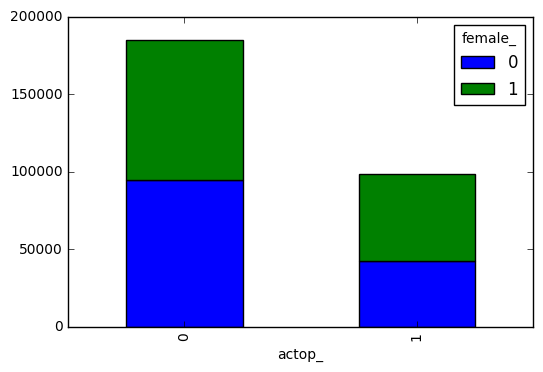

In [7]:
pd.crosstab(eec15.actop_, eec15.female_).plot(kind='bar', stacked=True)

In [8]:
print "Probability of employment:", eec15["actop_"].mean()

Probability of employment: 0.347426515966


### Multiple Linear Regression

In [9]:
# Build a list of parameters to include in the model, using regex
# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
params = {
    "age": "^age[0-9]{2}_$",
    "diploma": "^dip[0-9]{2}_$",
    "etranger": "^etranger_$",
    "domtom": "^domtom_$",
#     "trim": "^trim$",
    "female": "^female_$",
    "enfants": "^enfants_$",
#     "female_enfants": "^female_enfants_$",
    "region": "^region[1-2]_$"
}
params = {k: sorted([x for x in eec15.columns if re.match(r, x)]) for (k, r) in params.items()}

# Avoid the dummy variable trap
params = {k: (v if len(v) == 1 else v[:-1]) for (k, v) in params.items()}

# Convert to a list
params = sum(params.values(), [])
params += ["region2_"]

#### Train the model using `trim=1` data

In [10]:
eec15_t1 = eec15[eec15.trim == 1]
X_t1 = eec15_t1[params]
y_t1 = eec15_t1["actop_"]

In [11]:
# Fit using `sklearn` (`fit_intercept`: whether to calculate the constant or not)
reg_ols_sk = linear_model.LinearRegression(fit_intercept=True).fit(X_t1, y_t1)

# Fit using `statsmodels`
reg_ols_sm = sm.OLS(y_t1, sm.add_constant(X_t1)).fit(disp=False)

# Print the (`statsmodels`) model summary
reg_ols_sm.summary()

/Users/nicolaskhadivi/Dropbox/Git/econml/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actop_   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1400.
Date:                Sat, 04 Feb 2017   Prob (F-statistic):               0.00
Time:                        12:31:08   Log-Likelihood:                -38183.
No. Observations:               72838   AIC:                         7.641e+04
Df Residuals:                   72818   BIC:                         7.659e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3677      0.007     52.357      0.000         0.354     0.381
etranger_      0.1289      0.006     20.711      0.000         0.117     0.141
age15_         0.3206      0.004     72.382      0.000         0.312     0.329
age30_         0.0495      0.005     10.438      0.000         0.040     0.059
age40_        -0.0073      0.004     -1.634      0.102        -0.016     0.001
dip10_        -0.3453      0.006    -58.146      0.000        -0.357    -0.334
dip11_        -0.3799      0.009    -41.620      0.000        -0.398    -0.362
dip30_        -0.2223      0.016    -13.832      0.000        -0.254    -0.191
dip31_        -0.3302      0.007    -50.711      0.000        -0.343    -0.317
dip33_        -0.3673      0.011    -34.146      0.000        -0.388    -0.346
dip41_        -0.0953      0.007    -13.720      0.000        -0.109    -0.082
dip42_        -0.2746      0.006    -46.937      0.000        -0.286    -0.263
dip50_        -0.2058      0.005    -40.387      0.000        -0.216    -0.196
dip60_         0.0370      0.006      5.957      0.000         0.025     0.049
dip70_        -0.0465      0.013     -3.512      0.000        -0.072    -0.021
female_        0.0841      0.003     27.211      0.000         0.078     0.090
enfants_      -0.0717      0.004    -20.034      0.000        -0.079    -0.065
region1_       0.0348      0.005      6.500      0.000         0.024     0.045
domtom_        0.1124      0.005     23.147      0.000         0.103     0.122
region2_       0.0448      0.008      5.956      0.000         0.030     0.060
==============================================================================
Omnibus:                     4664.504   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4251.511
Skew:                           0.529   Prob(JB):                         0.00
Kurtosis:                       2.468   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Compare the coefficients from both fits (they should be the same)
regressors = list(X_t1.columns) + ["const"]

coeffs = pd.DataFrame(index=regressors)
coeffs["sm"] = reg_ols_sm.params
coeffs["sk"] = pd.Series(np.append(reg_ols_sk.coef_, reg_ols_sk.intercept_), index=regressors)
coeffs["diff"] = coeffs["sm"] - coeffs["sk"]

coeffs.sort_index().transpose()

,age15_,age30_,age40_,const,dip10_,dip11_,dip30_,dip31_,dip33_,dip41_,dip42_,dip50_,dip60_,dip70_,domtom_,enfants_,etranger_,female_,region1_,region2_
sm,0.3206,0.0495,-0.0073,0.3677,-0.3453,-0.3799,-0.2223,-0.3302,-0.3673,-0.0953,-0.2746,-0.2058,0.0370,-0.0465,0.1124,-0.0717,0.1289,0.0841,0.0348,0.0448
sk,0.3206,0.0495,-0.0073,0.3677,-0.3453,-0.3799,-0.2223,-0.3302,-0.3673,-0.0953,-0.2746,-0.2058,0.0370,-0.0465,0.1124,-0.0717,0.1289,0.0841,0.0348,0.0448
diff,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000


In [13]:
# Check the accuracy of the model on the training set
print "Accuracy: {}".format(reg_ols_sk.score(X_t1, y_t1))

Accuracy: 0.267547086265


#### `trim=2`

In [13]:
eec15_t2 = eec15[eec15.trim == 2]
X_t2 = eec15_t2[params]
y_t2 = eec15_t2["actop_"]

In [14]:
# Probabilité à partir de laquelle on considère qu'un individu est au chômage
THRESHOLD = 0.5

prediction = reg_ols.predict(X_t2)
prediction = np.where(prediction < THRESHOLD, 0, 1)

print metrics.accuracy_score(y_t2, prediction)

0.768136816199


In [15]:
# Using `statsmodel`
X_t2_const = sm.add_constant(X_t2) ## X_ est X + une cst
reg_ols_sm = sm.OLS(y_t2, X_t2)

results = reg_ols_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actop_   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3858.
Date:                Tue, 31 Jan 2017   Prob (F-statistic):               0.00
Time:                        22:22:49   Log-Likelihood:                -38330.
No. Observations:               71512   AIC:                         7.670e+04
Df Residuals:                   71493   BIC:                         7.687e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
etranger_      0.1565      0.006     24.635      0.000         0.144     0.169
age15_         0.3942      0.004     92.113      0.000         0.386     0.403
age30_         0.0966      0.005     20.385      0.000         0.087     0.106
age40_         0.0469      0.004     10.610      0.000         0.038     0.056
dip10_        -0.2563      0.006    -44.738      0.000        -0.268    -0.245
dip11_        -0.2759      0.009    -30.288      0.000        -0.294    -0.258
dip30_        -0.1124      0.016     -6.867      0.000        -0.144    -0.080
dip31_        -0.2298      0.006    -36.405      0.000        -0.242    -0.217
dip33_        -0.2665      0.011    -24.615      0.000        -0.288    -0.245
dip41_        -0.0145      0.007     -2.120      0.034        -0.028    -0.001
dip42_        -0.1737      0.006    -31.242      0.000        -0.185    -0.163
dip50_        -0.0889      0.005    -19.525      0.000        -0.098    -0.080
dip60_         0.1384      0.006     23.362      0.000         0.127     0.150
dip70_         0.1008      0.013      7.542      0.000         0.075     0.127
female_        0.1197      0.003     38.651      0.000         0.114     0.126
enfants_      -0.0401      0.004    -11.146      0.000        -0.047    -0.033
region1_       0.2265      0.004     56.034      0.000         0.219     0.234
domtom_        0.1538      0.005     31.371      0.000         0.144     0.163
region2_       0.2351      0.007     35.146      0.000         0.222     0.248
==============================================================================
Omnibus:                     4068.871   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4185.571
Skew:                           0.554   Prob(JB):                         0.00
Kurtosis:                       2.579   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cleanup

Now that the experiments have concluded, we delete all the "temporary" files.

In [16]:
for temp in temp_files:
    os.remove(temp)